In [12]:
#引入对应的模块
import torch
import numpy as np
import torchvision
import random
import copy
from tqdm import tqdm
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

def cw_l2_attack(model, images, labels, targeted=False, c=8, kappa=0, max_iter=1000, learning_rate=0.01):

    # 定义目标函数f
    def f(x):
        # 论文中的 Z(X) 输出 batchsize, num_classes
        outputs = model(x)
        # 就是一个one-hot编码,然后预测类别为1,其余为0，共有batch_size行，然后每行根据label置为0或1
        one_hot_labels = torch.eye(len(outputs[0])).to(device)[labels]
        # 1-one_hot_labels就是字面意思，原来是0的，就是1-0=1，原来是1的就是1-1=0，经过处理后除了真实类别以外的都是1
        # 水平方向最大的取值，忽略索引。意思是，除去真实标签，看看每个 batchsize 中哪个标签的概率最大，取出概率
        # 概率值, 标号
        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        # 选择真实标签的概率
        j = torch.masked_select(outputs, one_hot_labels.bool())

        # 如果有攻击目标，虚假概率减去真实概率，
        if targeted:
            # 如果 i - j 的计算结果小于 -kappa，那么使用 -kappa 作为结果，而不是原始值。
            return torch.clamp(i - j, min=-kappa)
        # 没有攻击目标，就让真实的概率小于虚假的概率，逐步降低，也就是最小化这个损失
        else:
            return torch.clamp(j - i, min=-kappa)
        

    w = torch.zeros_like(images, requires_grad=True).to(device)
    optimizer = torch.optim.Adam([w], lr=learning_rate)
    
    prev = 1e10

    for step in range(max_iter):
        a = 1 / 2 * (nn.Tanh()(w) + 1)
        # 最小化目标的两个部分
        # 第一个目标，对抗样本与原始样本足够接近
        loss1 = nn.MSELoss(reduction='sum')(a, images)
        # 第二个目标，误导模型输出
        loss2 = torch.sum(c * f(a))

        cost = loss1 + loss2
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % (max_iter // 10) == 0:
            if cost > prev:
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost

    attack_images = 1 / 2 * (nn.Tanh()(w) + 1)

    return attack_images

In [13]:
mean = 0.1307
std = 0.3801

# 对图像变换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
]
)
train_dataset = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=True)

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
import torch
print(torch.__version__)
print(torch.version.cuda)  # 如果是 None，说明是 CPU 版本

cuda:0
2.9.1+cu126
12.6


In [15]:
# 搭建LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # 卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, img):
        img = self.conv(img)
        img = img.view(img.size(0), -1)
        out = self.fc(img)
        # out = self.softmax(out)
        
        return out
    
net = LeNet()
net = net.to(device)
lr = 1e-3
epochs = 20
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=0.0000001)

  5%|▌         | 1/20 [00:21<06:57, 21.99s/it]

epoch:1  train_loss:0.3058, train_acc:0.9028, val_loss:0.0833, val_acc:0.9734275477707006


 10%|█         | 2/20 [00:39<05:47, 19.32s/it]

epoch:2  train_loss:0.0926, train_acc:0.9715, val_loss:0.0816, val_acc:0.9735270700636943


 15%|█▌        | 3/20 [00:56<05:09, 18.24s/it]

epoch:3  train_loss:0.0911, train_acc:0.9719, val_loss:0.0792, val_acc:0.9745222929936306


 20%|██        | 4/20 [01:12<04:41, 17.59s/it]

epoch:4  train_loss:0.0897, train_acc:0.9724, val_loss:0.0781, val_acc:0.9749203821656051


 25%|██▌       | 5/20 [01:30<04:24, 17.66s/it]

epoch:5  train_loss:0.0884, train_acc:0.9728, val_loss:0.0767, val_acc:0.9756170382165605


 30%|███       | 6/20 [01:48<04:08, 17.76s/it]

epoch:6  train_loss:0.0872, train_acc:0.9732, val_loss:0.0756, val_acc:0.9759156050955414


 35%|███▌      | 7/20 [02:05<03:48, 17.57s/it]

epoch:7  train_loss:0.0862, train_acc:0.9734, val_loss:0.0747, val_acc:0.9761146496815286


 40%|████      | 8/20 [02:23<03:32, 17.72s/it]

epoch:8  train_loss:0.0853, train_acc:0.9737, val_loss:0.0739, val_acc:0.9763136942675159


 45%|████▌     | 9/20 [02:42<03:17, 17.93s/it]

epoch:9  train_loss:0.0845, train_acc:0.9741, val_loss:0.0737, val_acc:0.9761146496815286


 50%|█████     | 10/20 [02:59<02:55, 17.58s/it]

epoch:10  train_loss:0.0838, train_acc:0.9742, val_loss:0.0730, val_acc:0.9767117834394905


 55%|█████▌    | 11/20 [03:16<02:37, 17.48s/it]

epoch:11  train_loss:0.0832, train_acc:0.9743, val_loss:0.0719, val_acc:0.9772093949044586


 60%|██████    | 12/20 [03:31<02:14, 16.87s/it]

epoch:12  train_loss:0.0827, train_acc:0.9743, val_loss:0.0719, val_acc:0.9773089171974523


 65%|██████▌   | 13/20 [03:47<01:55, 16.52s/it]

epoch:13  train_loss:0.0821, train_acc:0.9746, val_loss:0.0710, val_acc:0.9777070063694268


 70%|███████   | 14/20 [04:03<01:37, 16.26s/it]

epoch:14  train_loss:0.0818, train_acc:0.9747, val_loss:0.0718, val_acc:0.9774084394904459


 75%|███████▌  | 15/20 [04:17<01:18, 15.63s/it]

epoch:15  train_loss:0.0813, train_acc:0.9749, val_loss:0.0727, val_acc:0.9765127388535032


 80%|████████  | 16/20 [04:34<01:04, 16.05s/it]

epoch:16  train_loss:0.0809, train_acc:0.9751, val_loss:0.0701, val_acc:0.9778065286624203


 85%|████████▌ | 17/20 [04:51<00:48, 16.28s/it]

epoch:17  train_loss:0.0807, train_acc:0.9752, val_loss:0.0696, val_acc:0.977906050955414


 90%|█████████ | 18/20 [05:07<00:32, 16.34s/it]

epoch:18  train_loss:0.0803, train_acc:0.9753, val_loss:0.0706, val_acc:0.9776074840764332


 95%|█████████▌| 19/20 [05:22<00:15, 15.98s/it]

epoch:19  train_loss:0.0800, train_acc:0.9755, val_loss:0.0694, val_acc:0.9777070063694268


100%|██████████| 20/20 [05:39<00:00, 16.99s/it]

epoch:20  train_loss:0.0797, train_acc:0.9756, val_loss:0.0692, val_acc:0.9777070063694268


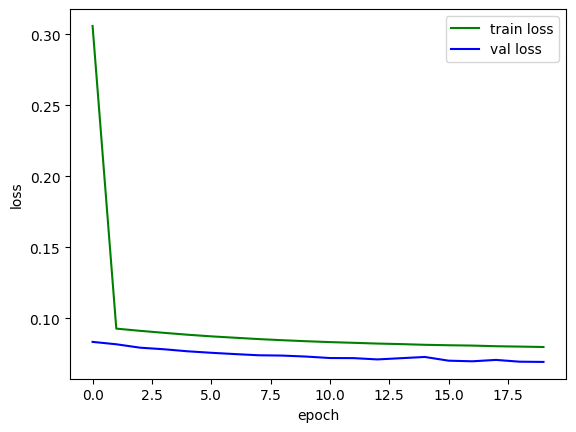

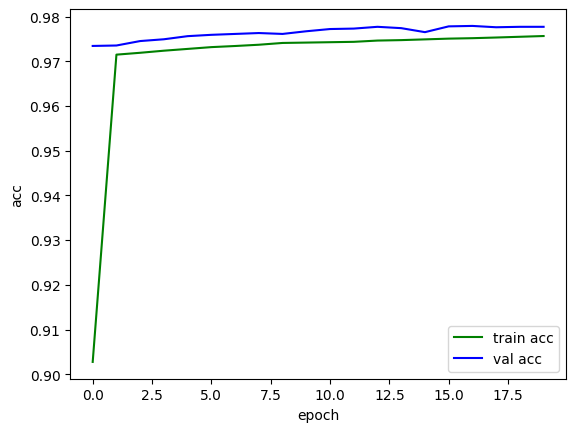

In [16]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in tqdm(range(epochs)):
    train_losses = 0
    train_acces = 0
    val_losses = 0
    val_acces = 0
    
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        output = net(x)
        # 计算loss
        loss = criterion(output, y)
        # 计算预测值
        _, pred = torch.max(output, axis=1)
        # 计算acc
        acc = torch.sum(y == pred) / output.shape[0]

        # 反向传播
        # 梯度清零
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses += loss.item()
        train_acces += acc.item()

    train_loss.append(train_losses / len(train_dataloader))
    train_acc.append(train_acces / len(train_dataloader))

    # 模型评估
    net.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            output = net(x)
            loss = criterion(output, y)
            scheduler.step(loss)
            _, pred = torch.max(output, axis=1)
            acc = torch.sum(y == pred) / output.shape[0]

            val_losses += loss.item()
            val_acces += acc.item()
        
        val_loss.append(val_losses / len(test_dataloader))
        val_acc.append(val_acces / len(test_dataloader))

    print(f"epoch:{epoch+1}  train_loss:{train_losses / len(train_dataloader):.4f}, train_acc:{train_acces / len(train_dataloader):.4f}, val_loss:{val_losses / len(test_dataloader):.4f}, val_acc:{val_acces / len(test_dataloader)}")

plt.plot(train_loss, color='green', label='train loss')
plt.plot(val_loss, color='blue', label='val loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plt.plot(train_acc, color='green', label='train acc')
plt.plot(val_acc, color='blue', label='val acc')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()

PATH = r'./cw_mnist_lenet.pth'
torch.save(net, PATH)

In [17]:
# 用于可视化
adv_examples = []
correct = 0
vis_max = 10
vis_num = 0
rand_num = -1

for data, label in  test_dataloader:
    data, label = data.to(device), label.to(device)
    attack_data = cw_l2_attack(model=net, images=data, labels=label)
    output = net(attack_data)
    _, pred = torch.max(output, axis=1)
    # print(label)
    # print(pred)
    # print(sum(pred == label))
    # 统计一下攻击以后正确的数量
    correct += torch.sum(pred == label)
    rand_num = torch.randint(0, 11, (1,))
    if rand_num % 2 == 0 and vis_num < vis_max:
        adv_examples.append((data, label, attack_data, pred))
        vis_num += 1

print("Attack accuracy:", float(correct) / len(test_dataset))

Attack accuracy: 0.0772


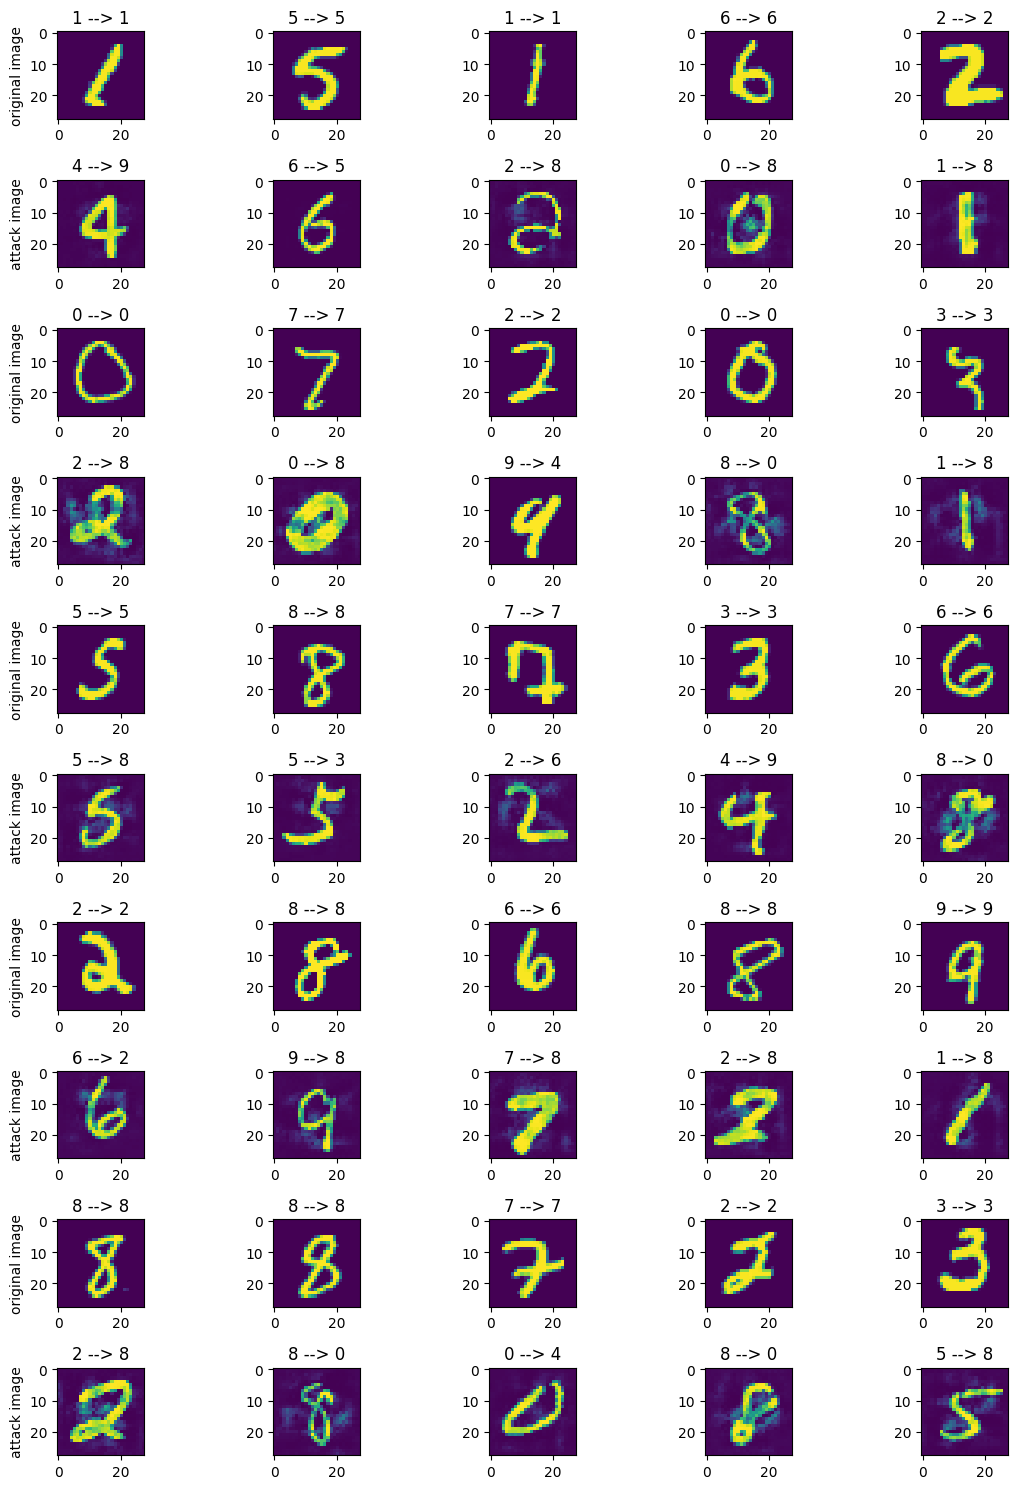

In [18]:
plt.figure(figsize=(12, 15))
index = 0
# 当前行画的图片
current = 0
# 设置当前行画原始还是攻击
odd = 0
for i in range(len(adv_examples)):
    data, label, attack_data, pred = adv_examples[i]
    current = 0
    for j in range(len(adv_examples[i][1])):
        # 一个批次的数据只画5张
        if label[j] != pred[j] and current < 5:
            index += 1
            current += 1
            plt.subplot(len(adv_examples), 5, index)
            if current == 1 and odd % 2 == 0:
                plt.ylabel("original image")            
            elif current == 1 and odd % 2 == 1:
                plt.ylabel("attack image")
                
            if odd % 2 == 1:
                print()
                plt.title("{} --> {}".format(label[j], pred[j]))
                plt.imshow(attack_data[j][0].cpu().detach().numpy())
            else:
                plt.title("{} --> {}".format(label[j], label[j]))
                plt.imshow(data[j][0].cpu().detach().numpy())
    odd += 1

    plt.tight_layout()